In [1]:
import numpy as np
import sfr_tomo as cib
import pyccl as ccl
import sacc
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from scipy.linalg import block_diag
import emcee
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)

## Obtain constraints on $\langle b\rho_{\rm SFR}\rangle$

In [2]:
COSMO_P18 = {"Omega_c": 0.26066676,
             "Omega_b": 0.048974682,
             "h": 0.6766,
             "n_s": 0.9665,
             "sigma8": 0.8102,
             "matter_power_spectrum": "linear"}
cosmo = ccl.Cosmology(**COSMO_P18)

In [3]:
def get_snus():
    from astropy.io import fits

    d = fits.open("data/filtered_snu_planck.fits")
    zs_CIB = d[1].data
    snus_CIB = {f'CIBLenz__{i}': d[0].data[i+3] for i in range(3)}
    return zs_CIB, snus_CIB

In [4]:
s = "data/cls_cov_minimal_newcov.fits"

In [5]:
class CIBLike(object):
    bgs = {'DELS__0': 1.1,
           'DELS__1': 1.4,
           'DELS__2': 1.3,
           'DELS__3': 1.74,
           'eBOSSQSO__0': 2.0,
           'eBOSSQSO__1': 2.5}
    bSs = {'DELS__0': 0.01,
           'DELS__1': 0.03,
           'DELS__2': 0.05,
           'DELS__3': 0.06,
           'eBOSSQSO__0': 0.15,
           'eBOSSQSO__1': 0.3}

    def __init__(self, fname_data, gcs, ivs, cosmo, kmax=0.15,
                 kmin_eBOSS=0.02, lmin=75, verbose=False):
        self.cosmo = cosmo

        # Read data
        if type(fname_data) == str:
            s = sacc.Sacc.load_fits(fname_data)
        else:
            s = fname_data

        # Create tracers
        zs, snus = get_snus()
        tracers = {t: cib.IvTracer(self.cosmo, snus[t], zs, z_min=0.07) for t in ivs}
        nzs = {t: (s.tracers[t].z, s.tracers[t].nz) for t in gcs}
        tracers.update({t: ccl.NumberCountsTracer(self.cosmo, False, dndz=nz,
                                                  bias=(nz[0], np.ones_like(nz[0])))
                        for t, nz in nzs.items()})

        # Clean data
        indices = []
        zmeans = []
        nl_temp = []
        for gc in gcs:
            zmean = nzs[gc][0][np.argmax(nzs[gc][1])]
            #zmean = np.average(nzs[gc][0], weights=nzs[gc][1])
            zmeans.append(zmean)
            chimean = ccl.comoving_radial_distance(self.cosmo, 1/(1+zmean))
            lmax = kmax*chimean-0.5
            if 'QSO' in gc:
                lmin = kmin_eBOSS*chimean-0.5
            else:
                lmin = lmin
            if verbose:
                print(gc, zmean, chimean, lmin, lmax)

            ind = s.indices('cl_00', (gc, gc), ell__gt=lmin, ell__lt=lmax)
            nl_temp += list(np.ones([1, len(ind)]))
            indices += list(ind)
            for iv in ivs:
                if 'QSO' in gc:
                    ts = (iv, gc)
                else:
                    ts = (gc, iv)
                ind = s.indices('cl_00', ts, ell__gt=lmin, ell__lt=lmax)
                indices += list(ind) 
                nl_temp += list(np.ones([1, len(ind)]))
        s.keep_indices(np.array(indices))
        self.zmeans = np.array(zmeans)

        # Construct 2pt metadata
        twopoints = []
        indices = []
        for gc in gcs:
            # Read data
            ls, cl, cov, ind = s.get_ell_cl('cl_00', gc, gc, return_cov=True, return_ind=True)
            # Compute theory template
            cl_th = self._get_cl(tracers[gc], tracers[gc], s, ls, ind)
            # Store
            twopoints.append({'bin1': gc, 'bin2': gc, 'cov': cov, 'ind': ind,
                              'cld': cl, 'clt': cl_th, 'ls': ls})
            indices += list(ind)
            for iv in ivs:
                if 'QSO' in gc:
                    t1 = iv
                    t2 = gc
                else:
                    t1 = gc
                    t2 = iv
                ls, cl, cov, ind = s.get_ell_cl('cl_00', t1, t2, return_cov=True, return_ind=True)
                cl_th = self._get_cl(tracers[gc], tracers[iv], s, ls, ind)
                twopoints.append({'bin1': gc, 'bin2': iv, 'cov': cov, 'ind': ind,
                                  'cld': cl, 'clt': cl_th, 'ls': ls})
                indices += list(ind)
        indices = np.array(indices)
        data_vec = s.mean[indices]
        cv = s.covariance.dense[indices][:, indices]
        icv = np.linalg.inv(cv)
        n_cl = len(twopoints)
        # [n_cl, n_data]
        nl_tmat = block_diag(*nl_temp)
        # [n_data, n_cl]
        iC_T = np.einsum('ij,kj', icv, nl_tmat)
        # [n_cl, n_cl]
        T_iC_T = np.einsum('ij,jk', nl_tmat, iC_T)
        # [n_cl, n_cl]
        i_1_p_T_iC_T = np.linalg.inv(np.eye(n_cl)+T_iC_T)
        # Cinv_marg
        icv_marg = icv - np.einsum('ij,jk,lk',
                                   iC_T, i_1_p_T_iC_T, iC_T)
        self.tps = twopoints
        self.cov = cv
        self.icov = icv
        self.icov_marg = icv_marg
        self.icv = self.icov_marg
        self.dvec = data_vec
        self.gcs = gcs
        self.ivs = ivs
        if verbose:
            for t in self.tps:
                print(t['bin1'], t['bin2'], len(t['ls']))

        self.parnames = []
        self.par_ind = {}
        ind = 0
        for gc in gcs:
            self.parnames.append(f'bg_{gc}')
            self.par_ind[f'bg_{gc}'] = ind
            ind += 1
            self.parnames.append(f'bS_{gc}')
            self.par_ind[f'bS_{gc}'] = ind
            ind += 1
        self.n_pars = ind
        if verbose:
            for p in self.parnames:
                print(self.par_ind[p], p)

    def _get_cl(self, tr1, tr2, sfile, ls, inds):
        bpw = sfile.get_bandpower_windows(inds)
        ell = bpw.values
        # Could use interpolation here
        cl = ccl.angular_cl(self.cosmo, tr1, tr2, ell)
        return np.dot(bpw.weight.T, cl)

    def list_to_params(self, plist):
        return {n: p for n, p in zip(self.parnames, plist)}

    def params_to_list(self, pars):
        parlist = np.zeros(self.n_pars)
        for k, v in pars.items():
            parlist[self.par_ind[k]] = v
        return parlist

    def get_default_params(self, return_list=False):
        pars = {}
        for gc in self.gcs:
            pars[f'bg_{gc}'] = self.bgs[gc]
            pars[f'bS_{gc}'] = self.bSs[gc]
        if return_list:
            return self.params_to_list(pars)
        else:
            return pars

    def get_predictions(self, params):
        pred = []
        for tp in self.tps:
            t1 = tp['bin1']
            t2 = tp['bin2']
            b1 = params.get(f'bg_{t1}', 1.0)
            if t1 == t2:  # gg
                b2 = b1
            else:
                b2 = params[f'bS_{t1}']
            pred.append({'bin1': t1, 'bin2': t2,
                         'cl': tp['clt']*b1*b2})
        return pred

    def chi2(self, plist):
        pars = self.list_to_params(plist)
        pred = self.get_predictions(pars)
        tvec = np.hstack(np.array([p['cl'] for p in pred]))
        r = self.dvec - tvec
        c2 = np.dot(r, np.dot(self.icv, r))
        return c2

    def logprob(self, plist):
        return -0.5*self.chi2(plist)

### 1. Initialize likelihood

In [6]:
gcs = ['DELS__0', 'DELS__1', 'DELS__2', 'DELS__3', 'eBOSSQSO__0', 'eBOSSQSO__1']
ivs = ['CIBLenz__0', 'CIBLenz__1', 'CIBLenz__2']
like = CIBLike(s, gcs, ivs, cosmo, verbose=False, lmin=100, kmax=0.15)

### 2. Minimize chi2

In [7]:
p0 = like.get_default_params(return_list=True)
pBF = minimize(like.chi2, p0, method='Powell').x
for k, v in like.list_to_params(pBF).items():
    if k[0] == 'n':
        continue
    print(k, v)
print(like.chi2(pBF))

<ipython-input-5-e162745308e1>:174: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tvec = np.hstack(np.array([p['cl'] for p in pred]))


bg_DELS__0 1.0428037036400923
bS_DELS__0 -0.005403321783232913
bg_DELS__1 1.3303546345153054
bS_DELS__1 0.025385275290800164
bg_DELS__2 1.269244080899853
bS_DELS__2 0.0397252835048049
bg_DELS__3 1.6934211823591678
bS_DELS__3 0.046802686702249505
bg_eBOSSQSO__0 2.053720852676942
bS_eBOSSQSO__0 0.10690039969353353
bg_eBOSSQSO__1 2.1872123083248174
bS_eBOSSQSO__1 0.2522315525802883
200.24503519452068


### 3. Get samples

In [8]:
nwalkers = 32
npars = len(pBF)
nsteps = 20000

pos = (pBF +
       0.001 * np.random.randn(nwalkers, npars))
sampler = emcee.EnsembleSampler(nwalkers, npars, like.logprob)
sampler.run_mcmc(pos, nsteps, progress=True)

<ipython-input-5-e162745308e1>:174: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tvec = np.hstack(np.array([p['cl'] for p in pred]))
100%|██████████| 20000/20000 [02:20<00:00, 142.43it/s]


State([[ 1.06954774e+00 -8.67932183e-03  1.28455613e+00  3.42241252e-02
   1.26900029e+00  3.51021645e-02  1.68205395e+00  3.93345145e-02
   2.23995814e+00  9.25680785e-02  1.90210632e+00  2.54135621e-01]
 [ 1.00280522e+00 -1.23070781e-02  1.30298045e+00  2.40771656e-02
   1.27186476e+00  4.20433456e-02  1.66976276e+00  4.79599255e-02
   2.10765122e+00  1.09838747e-01  2.14919342e+00  2.32124481e-01]
 [ 1.08359731e+00 -1.92382310e-02  1.34305076e+00  2.38566493e-02
   1.25288258e+00  3.53150411e-02  1.66902282e+00  4.52633933e-02
   2.21721850e+00  1.03992822e-01  2.23735919e+00  2.49556264e-01]
 [ 1.02526183e+00 -5.22798923e-03  1.31105638e+00  2.78174635e-02
   1.26847173e+00  4.31466838e-02  1.69682540e+00  4.77913437e-02
   2.19370416e+00  7.26656845e-02  2.25101342e+00  2.25703591e-01]
 [ 1.03179312e+00 -8.44081767e-03  1.31978397e+00  2.48473481e-02
   1.24853679e+00  4.45892220e-02  1.69772117e+00  5.47414743e-02
   2.13102440e+00  1.20838555e-01  1.90307452e+00  3.24042609e-01]

In [9]:
chain = sampler.get_chain(discard=500, flat=True)
for i, (k, v) in enumerate(like.list_to_params(pBF).items()):
    cc = chain[:, i]
    print(k, v, np.mean(cc), np.std(cc))

bg_DELS__0 1.0428037036400923 1.0385203286418296 0.04314249953024632
bS_DELS__0 -0.005403321783232913 -0.005686241619358636 0.008415600747754446
bg_DELS__1 1.3303546345153054 1.3281030369976903 0.02521303298195832
bS_DELS__1 0.025385275290800164 0.02526659777829835 0.005563281103733387
bg_DELS__2 1.269244080899853 1.2685358567409517 0.015866198510852338
bS_DELS__2 0.0397252835048049 0.039612690049067804 0.005064456147738455
bg_DELS__3 1.6934211823591678 1.6930942108423679 0.01860183731142719
bS_DELS__3 0.046802686702249505 0.046693868050093026 0.005126449763436456
bg_eBOSSQSO__0 2.053720852676942 2.02758046152358 0.14830684950629297
bS_eBOSSQSO__0 0.10690039969353353 0.1084547784472578 0.01341856856395499
bg_eBOSSQSO__1 2.1872123083248174 2.150263736392374 0.18957659130711468
bS_eBOSSQSO__1 0.2522315525802883 0.2576037940613765 0.031931026717586776


Removed no burn in


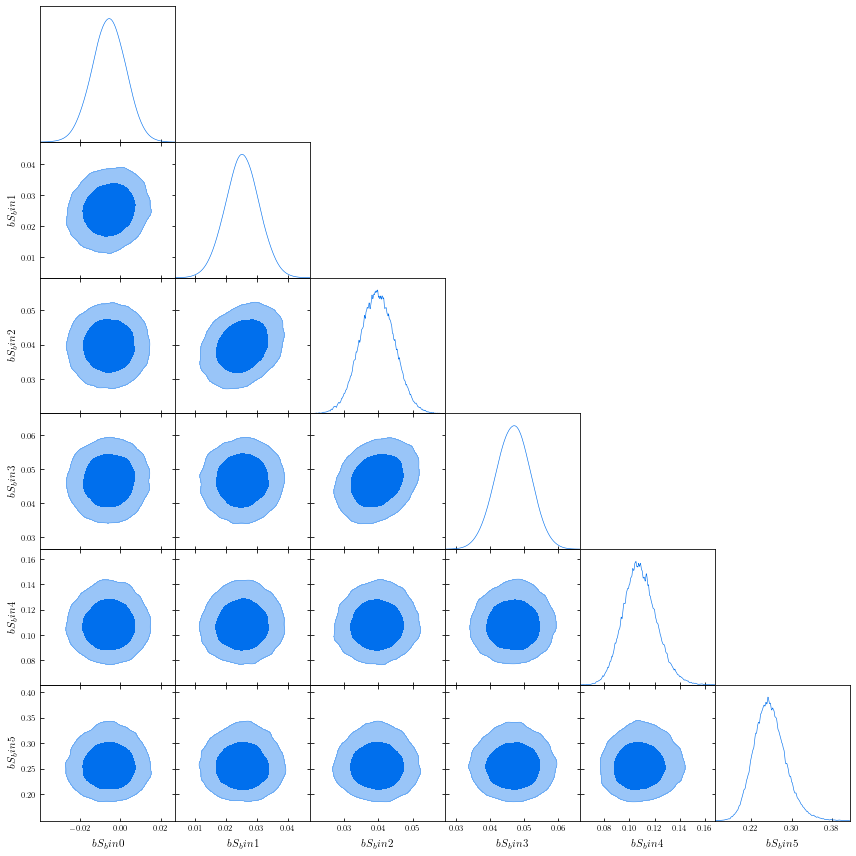

In [10]:
from getdist import MCSamples
from getdist import plots as gplots

chain_bS = chain[:, 1::2]

nsamples = len(chain)
# Generate samples
samples = MCSamples(samples=chain_bS,
                    names=[f'bS_bin{i}' for i in range(6)],
                    labels=[f'bS_bin{i}' for i in range(6)])
samples.smooth_scale_2D=0.2

# Triangle plot
g = gplots.getSubplotPlotter()
g.triangle_plot([samples], filled=True)

In [11]:
bS_mean = np.mean(chain_bS, axis=0)
bS_cov = np.cov(chain_bS.T)
np.savez("data/bSFR_kmax0p15_allbins_allfreq_linear.npz",
         zs=like.zmeans, means=bS_mean, cov=bS_cov, chain=chain_bS)

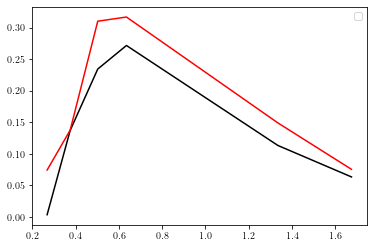

In [19]:
ds1 = [np.load("data/bSFR_kmax0p15_allbins_allfreq.npz"),
       np.load("data/bSFR_kmax0p15_allbins_allfreq_linear.npz")]
ds2 = [np.load("data/bSFR_kmax0p20_allbins_allfreq.npz"),
       np.load("data/bSFR_kmax0p20_allbins_allfreq_linear.npz")]
plt.plot(ds1[0]['zs'], (ds1[0]['means']-ds1[1]['means'])/np.sqrt(np.diag(ds1[0]['cov'])), 'k-')
plt.plot(ds2[0]['zs'], (ds2[0]['means']-ds2[1]['means'])/np.sqrt(np.diag(ds2[0]['cov'])), 'r-')
plt.legend()